<a href="https://colab.research.google.com/github/davidashirov/uzum_biz_an/blob/main/David_Ashirov_HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическое задание 2
# Классификация заемщиков линейными моделями

## Студент: Давид Аширов

## Формулировка задания
Данное задание направлено на ознакомление с линейными моделями.

От вас требуется:
1. Загрузить данные
2. Провести первичный анализ данных, изучить имеющиеся признаки
3. Провести обработку данных и обучить простую линейную модель
4. С помощью кросс-валидации + GridSearch подобрать основные параметры для линейной модели. Провести простой отбор признаков
5. Посмотреть как изменение остальных параметров влияет на метрики
6. Оценить качество полученной модели

## 1. Загрузка данных (5 баллов)

Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). Для экспериментов будем использовать лишь основной файл `application_train.csv`, а также перекодируем таргет в метки -1, 1.

Описание колонок находится в файле `description.csv`.

Для начала мы за вас считаем данные и поделим на обучение, валидацию и тест случайным образом.

In [7]:
# Чтобы данные скачать, их надо сначала загрузить и распаковать
!mkdir -p 'data'
!wget -N 'https://github.com/SergeyMalashenko/MachineLearning_Summer_2023/raw/main/homeworks/10.%20Linear%20Models/data/application_train.zip' -P 'data' -q
!wget -N 'https://github.com/SergeyMalashenko/MachineLearning_Summer_2023/raw/main/homeworks/10.%20Linear%20Models/data/HomeCredit_columns_description.csv' -P 'data' -q
!unzip -n -d 'data' '/content/data/application_train.zip'
!rm 'data/application_train.zip'

Archive:  /content/data/application_train.zip
  inflating: data/application_train.csv  


In [8]:
from pathlib import Path
path = Path('/content/data/application_train.csv')

In [9]:
import numpy as np, pandas as pd

data = pd.read_csv(path)
data.columns = ['_'.join([word.lower() for word in col_name.split(' ') if word != '-']) for col_name in data.columns]

data.target = data.target.map({0: -1, 1: 1})

from IPython.display import display

print('\ntarget value_counts:')
display(data['target'].value_counts(dropna=False))

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

data.head(5)


target value_counts:


-1    282686
 1     24825
Name: target, dtype: int64

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,-1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,-1,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,-1,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Sing

In [10]:
X, y = data.drop(['target'],axis=1), data.target


## 2. Первичный анализ данных, изучение признаков (5 баллов)

Изучите признаки, которые имеются в датасете.  
Какие из них относятся к каким типам?
Как они коррелируют с целевой переменной?

In [11]:
# TODO
# Проведите первичное изучение признаков

def extract_col_info(X_train):
  descr = pd.read_csv(path.parent/'HomeCredit_columns_description.csv', encoding='ISO-8859-1')[:len(X_train.columns)+1]

  print(f'Dataset has {len(X_train.columns)} columns')
  print('Special notes about columns:')
  print(descr.Special.value_counts())

  descr.drop(['Unnamed: 0', 'Table'], axis=1, inplace=True)
  descr.drop([1], axis=0,inplace=True)
  descr['Datatype'] = X_train.dtypes.astype(str).values
  descr['Unique'] = X_train.nunique().values
  descr['NaNs'] = X_train.isnull().sum().values
  descr['PercentNaN'] = (X_train.isnull().sum()/len(X_train)*100).values
  descr['Row'] = descr['Row'].apply(lambda x: x.lower())
  return descr

descr = extract_col_info(X)
descr.head(5)

Dataset has 121 columns
Special notes about columns:
normalized                               50
time only relative to the application     4
normalized                                1
rounded                                   1
Name: Special, dtype: int64


,Row,Description,Special,Datatype,Unique,NaNs,PercentNaN
0,sk_id_curr,ID of loan in our sample,NaN,int64,307511,0,0.0
2,name_contract_type,Identification if loan is cash or revolving,NaN,object,2,0,0.0
3,code_gender,Gender of the client,NaN,object,3,0,0.0
4,flag_own_car,Flag if the client owns a car,NaN,object,2,0,0.0
5,flag_own_realty,Flag if client owns a house or flat,NaN,object,2,0,0.0


In [12]:
# Можно было бы просто заменить отствующие данные, но так мы теряем информацию - отсутствие данных тоже о чем то может говорить
from sklearn.impute import SimpleImputer
imputer_median = SimpleImputer(strategy='median')
imputer_freq = SimpleImputer(strategy='most_frequent')

# Drop user id
X = X.drop(['sk_id_curr'],axis=1)

# For each col: if there are NaNs - create a new bool column that indicates if the data was missing
for column in X.select_dtypes(include=['float64','object', 'int64']):
  if X[column].isnull().sum() > 0:
    X['isna_'+ column] = ~X[column].isnull()
    #print(column,': ', X[column].isnull().sum())

# Rename some categorical and int columns and convert to bool
X.rename(columns={"name_contract_type": "is_cash_loan"}, inplace=True)
X.rename(columns={"code_gender": "is_male"}, inplace=True)
X.rename(columns={"flag_own_car": "has_car"}, inplace=True)
X.rename(columns={"flag_own_realty": "has_realty"}, inplace=True)
X['is_cash_loan'] = X['is_cash_loan'].map({'Cash loans':True, 'Revolving loans':False},)
X['is_male'] = X['is_male'].map({'M':True, 'XNA':True, 'F':False})
X['has_car'] = X['has_car'].map({'Y':True, 'N':False})
X['has_realty'] = X['has_realty'].map({'Y':True, 'N':False})

# Impute numeric with median, object with most freq
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

X[numeric_cols] = imputer_median.fit_transform(X[numeric_cols] )
X[categorical_cols] = imputer_freq.fit_transform(X[categorical_cols])

X_dum = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)

In [13]:
# TODO
# Разбейте вашу выборку на трейн-тест-валидацию в пропорциях 0.5-0.2-0.3 соответственно
# Строки данных не связаны между собой, поэтому просто делим случайно

from sklearn.model_selection import train_test_split

seed = 1
X_train, X_temp, y_train, y_temp = train_test_split(X_dum, y, test_size=0.5)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.2/0.5, random_state=seed)

In [14]:
print(len(X_train))
print(len(X_test))
print(len(X_valid))

153755
61503
92253


Я не хочу тратить много времени на предв. анализ данных - я не разберусь в сотне колонок и сотнях тысяч строк. Самый надежный способ понять данные - построить модель и оценить важность признаков с ее помощью. Чем лучше модель - тем лучше инсайты, которые она может нам дать. Для этого хорошо подходит Random Forest - он выдает распределение важности признаков. К тому же, RF легко настроить, надежен, требует минимум обработки данных и выдает хороший результат.

In [15]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=10, n_jobs=-1, oob_score=True, verbose=1, class_weight='balanced')
forest.fit(X_train.astype('float64'),y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.0s finished


RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       oob_score=True, verbose=1)

In [16]:
print(f'Random forest OOB accuracy: {forest.oob_score_*100:.1f}%')

Random forest OOB accuracy: 72.1%


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.3s finished


Accuracy: 0.7219494216990233
roc_auc: 0.6617098680905947


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished


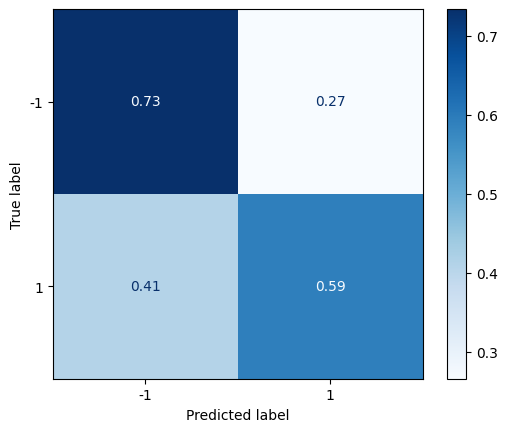

In [17]:
import matplotlib.pyplot as  plt
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay
y_pred = forest.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)

print(f"Accuracy: {accuracy}")
print(f"roc_auc: {roc_auc}")

disp = ConfusionMatrixDisplay.from_estimator(
        forest,
        X_valid,
        y_valid,
        display_labels=[-1,1],
        cmap=plt.cm.Blues,
        normalize='true',
    )

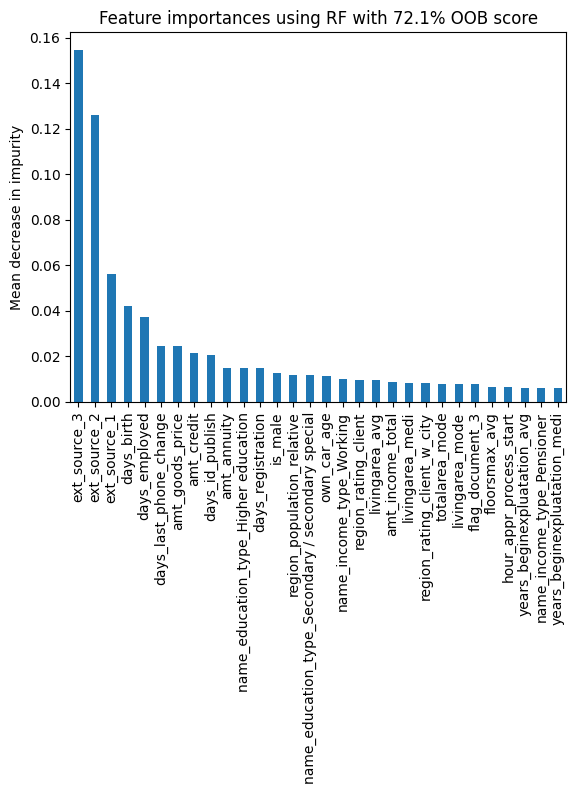

In [18]:
import matplotlib.pyplot as  plt
import seaborn as sns

forest_importances = pd.Series(forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = X_train.columns

fig, ax = plt.subplots()
forest_importances[:30].plot.bar(ax=ax)
ax.set_title(f'Feature importances using RF with {forest.oob_score_*100:.1f}% OOB score')
ax.set_ylabel("Mean decrease in impurity")
plt.show()

In [19]:
print(f'Least important: \n{forest_importances[-10:]}')

Least important: 
organization_type_Transport: type 1    0.0
name_income_type_Student               0.0
organization_type_Trade: type 5        0.0
organization_type_Trade: type 4        0.0
name_family_status_Unknown             0.0
isna_cnt_fam_members                   0.0
isna_amt_annuity                       0.0
organization_type_Industry: type 8     0.0
flag_document_10                       0.0
flag_document_12                       0.0
dtype: float64


Итак, мы имеем базовую модель и список признаков отсортированный по их важности для решения.
Ожидаемо, среди самых полезных признаков: аггрегированные кредитные скоры из внешних источников ext_source_# (кто-то уже провел для этого анализ), возраст, тип дохода, стаж, пол, наличие высшего образования, и т.д.
Среди самых неважных - предоставил ли некий документ соискатель, некоторые виды семейного статуса и день недели подачи заявления на кредит.
Это хорошо тем, что мы могли бы даже использовать линейную модель на наиболее важных признаках, уменьшив размерность пространства, улучшив интерпретируемость и возможно даже точность (но это не точно).


## 3. Обработка данных, обучение простой линейной модели  (5 баллов)

Изучите признаки, которые имеются в датасете.  
Какие из них относятся к каким типам?
Как они коррелируют с целевой переменной?
Обучите на ваших данных простую [Логистическую регресиию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)   
Какое качество вам удалось получить?


In [26]:
# TODO
# Проведите обработку признаков
# Обучение простую логистическую регресиию
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler().fit(X_train)

X_train_norm = scaler.transform(X_train)

logistic_regression = LogisticRegression(verbose=1, max_iter=1000,class_weight='balanced',n_jobs=-1)

logistic_regression.fit(X_train_norm, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1, verbose=1)

Accuracy: 0.685744637030774
roc_auc: 0.6835349457635237


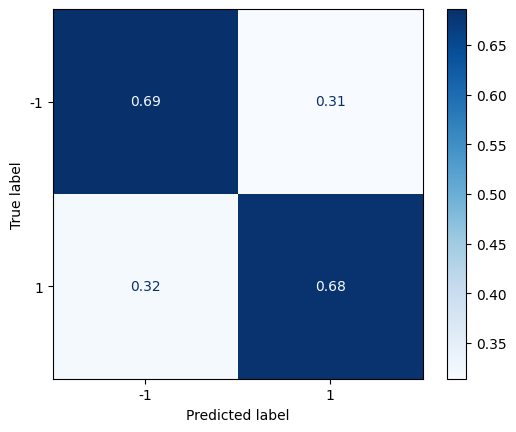

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay
X_valid_norm = scaler.transform(X_valid)
y_pred = logistic_regression.predict(X_valid_norm)

accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)

print(f"Accuracy: {accuracy}")
print(f"roc_auc: {roc_auc}")

disp = ConfusionMatrixDisplay.from_estimator(
        logistic_regression,
        X_valid_norm,
        y_valid,
        display_labels=[-1,1],
        cmap=plt.cm.Blues,
        normalize='true',
    )

Я подумал, что это плохой результат, но победитель на Kaggle набрал ROC AUC = 0.8 примерно, так что в качестве базовой модели сойдет.


## 4. Оценка поведения модели в зависимости от гиперпараметров  (5 баллов)

Попробуйте поперебирать значения гиперпараметров `l2_coef, batch_size`.   
Какая их комбинация выглядит оптимальной?




In [ ]:
# TODO
# Оцените качество модели в зависимости от l2_coef и batch_size




Мы не используем SGD, поэтому batch_size теряет смысл. Не знаю параметра l2_coef. Пробовал проверить l1 регуляризацию как замену. Но не смог из-за того, что fit не завершался очень долго c liblinear, который поддерживает оба вида регуляризации.


## 5. GridSearchCV. Отбор признаков  (5 баллов)


С помощью GridSearchCV подберите оптимальные параметры `step_alpha, step_beta` для фиксированных значений `l2_coef, batch_size` с предыдущего шага.  
Проведите отбор признаков любым из известных вам методов

In [30]:
import numpy as np
from sklearn.model_selection import GridSearchCV

X_cv = pd.concat([X_train, X_valid], axis=0)
y_cv = pd.concat([y_train, y_valid], axis=0)
X_cv_norm = scaler.transform(X_cv)

logistic_regression = LogisticRegression(max_iter=1000,class_weight='balanced',n_jobs=-1)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Values for the regularization strength (C)
}

grid_search = GridSearchCV(logistic_regression, param_grid, cv=2, scoring='roc_auc',verbose=1,error_score='raise')

grid_search.fit(X_cv_norm, y_cv)

best_C = grid_search.best_params_['C']

print("Best C:", best_C)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best C: 0.1



## 6. Оценка качества модели  (5 баллов)


Оцените качество модели с помощью известных вам метрик классификации.  
Что ещё в модели можно было бы улучшить?


In [34]:
logistic_regression = LogisticRegression(C=0.1, verbose=1, max_iter=1000,class_weight='balanced',n_jobs=-1)
logistic_regression.fit(X_train_norm, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, n_jobs=-1,
                   verbose=1)

Accuracy: 0.685744637030774
ROC AUC: 0.6792588121432738


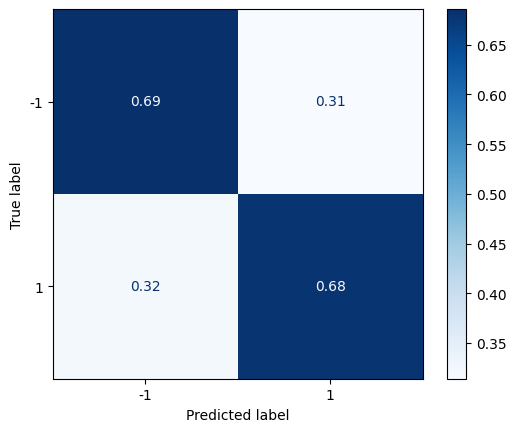

In [35]:
# TODO
# Оцените качество модели с помощью известных вам метрик

from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay
X_test_norm = scaler.transform(X_test)
y_pred = logistic_regression.predict(X_test_norm)

roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

disp = ConfusionMatrixDisplay.from_estimator(
        logistic_regression,
        X_valid_norm,
        y_valid,
        display_labels=[-1,1],
        cmap=plt.cm.Blues,
        normalize='true',
    )